In [291]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split as tts,GridSearchCV
import statsmodels.api as sm
from sklearn.linear_model import Lasso, LassoCV, ElasticNet, ElasticNetCV,LinearRegression,BayesianRidge,Ridge, LogisticRegression
from sklearn.svm import SVR
import sklearn.metrics as metrics
from sklearn.neighbors import KNeighborsRegressor as KNNR
import scipy
import plotly.plotly as py
import plotly.graph_objs as go
import pygsheets
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

%matplotlib inline
pd.options.display.max_rows=100
pd.options.display.max_columns=100

- Ideas
    - Trying other features
        - Total miles for week prior and month prior
        - Run % of total miles for prior week and month
        - Weighted avg of mph for previous week and month
        - Run mph difference from previous week and month mph avg
        - Average daily strain for previous week and month
        - Getting the paces from each lap
        - ?? If i take the strain per mile for the preceding week, is that going to bias my model too much??
    - Try an MCMC or another approach
- Timeline
    - do more extensive data cleaning during the week
    - convert models to DAG

In [418]:
gc = pygsheets.authorize(outh_file='/Users/irarickman/client_secret.json')
file = 'Activity data'
sh = gc.open(file)

wks_1 = sh[0]
strava=wks_1.get_as_df(empty_value=np.nan)
strava.dropna(how='all',inplace=True)

wks_2=sh[1]
whoop=wks_2.get_as_df(empty_value=np.nan)
whoop.dropna(how='all',inplace=True)
whoop.dropna(axis=1,how='all',inplace=True)

wks_3=sh[2]
acts=wks_3.get_as_df(empty_value=np.nan)
acts.dropna(how='all',inplace=True)
acts.dropna(axis=1,how='all',inplace=True)


In [419]:
print(strava.shape)
strava.columns

(277, 44)


Index(['achievement_count', 'athlete_count', 'average_speed', 'average_watts',
       'comment_count', 'commute', 'device_watts', 'distance', 'elapsed_time',
       'elev_high', 'elev_low', 'external_id', 'flagged', 'gear_id',
       'has_kudoed', 'id', 'kilojoules', 'kudos_count', 'manual', 'max_speed',
       'max_watts', 'moving_time', 'name', 'photo_count', 'private',
       'start_date', 'start_date_local', 'timezone', 'total_elevation_gain',
       'total_photo_count', 'trainer', 'type', 'upload_id',
       'weighted_average_watts', 'workout_type', 'miles', 'race',
       'date_string', 'moving_minutes', 'elapsed_minutes', 'rest', 'avg_mph',
       'time_since_last_act', 'order'],
      dtype='object')

In [420]:
strava.type.value_counts()

Run       210
Ride       38
Swim       27
Walk        1
Rowing      1
Name: type, dtype: int64

In [487]:
strava[['start_date_local','time_since_last_act']].sort_values('start_date_local').head()

,start_date_local,time_since_last_act
1,2018-04-01 08:54:18+00:00,-43.0
2,2018-04-03 06:35:19+00:00,-25.0
3,2018-04-04 06:58:33+00:00,-24.0
4,2018-04-05 06:29:13+00:00,-36.0
5,2018-04-06 17:56:04+00:00,-38.0


In [421]:
## creating group by variables
strava['week']=pd.to_datetime(strava.date_string).dt.strftime("%Y-%W")
strava['month']=pd.to_datetime(strava.date_string).dt.strftime("%Y-%m")
agg_month=strava[strava.type=='Run'].sort_values('date_string').groupby('month',group_keys=False).agg({
    "miles":{'miles_last_month':'sum'},
    'moving_minutes':{'minutes_last_month':'sum'}}).shift(1)
agg_month.columns=agg_month.columns.droplevel()
agg_month['avg_mph_last_month']=agg_month.miles_last_month/(agg_month.minutes_last_month/60.0)
agg_month.drop(['minutes_last_month'],axis=1,inplace=True)
agg_week=strava[strava.type=='Run'].sort_values('date_string').groupby('week',group_keys=False).agg({
    "miles":{'miles_last_week':'sum'},
    'moving_minutes':{'minutes_last_week':'sum'}}).shift(1)
agg_week.columns=agg_week.columns.droplevel()
agg_week['avg_mph_last_week']=agg_week.miles_last_week/(agg_week.minutes_last_week/60.0)
agg_week.drop(['minutes_last_week'],axis=1,inplace=True)
strava_agg=strava.merge(
    agg_month,how='left',left_on='month',right_index=True).merge(
    agg_week,how='left',left_on='week',right_index=True)

## going to fill the mph variables with the previous mph when applicable, but will fill with 0 since i'm creating a difference variable
## going to fill the miles variables with 1 since i'm doing % based off it
strava_agg[strava_agg.miles_last_week.isnull()]
strava_agg[['avg_mph_last_week','avg_mph_last_month']]=strava_agg[['avg_mph_last_week','avg_mph_last_month']].fillna(method='ffill')
strava_agg[['avg_mph_last_week','avg_mph_last_month']]=strava_agg[['avg_mph_last_week','avg_mph_last_month']].fillna(0)
strava_agg[['miles_last_week','miles_last_month']]=strava_agg[['miles_last_week','miles_last_month']].fillna(1)
strava_agg.drop(['week','month'],axis=1,inplace=True)

## creating the values for run as % of total miles for week and month
strava_agg['miles_pct_last_week']=strava_agg.miles/strava_agg.miles_last_week
strava_agg['miles_pct_last_month']=strava_agg.miles/strava_agg.miles_last_month

## creating the values for run speed difference from avg mph for week and month
strava_agg['mph_diff_last_week']=strava_agg.avg_mph - strava_agg.avg_mph_last_week
strava_agg['mph_diff_last_month']=strava_agg.avg_mph - strava_agg.avg_mph_last_month

/Users/irarickman/anaconda2/envs/py35/lib/python3.6/site-packages/pandas/core/groupby/groupby.py:4656: FutureWarning:

using a dict with renaming is deprecated and will be removed in a future version



In [422]:
## since there are some times where i accidentally stored a run as two separate activities, 
## trying to find them to see if it's worth it to join them
strava_agg['multi_act']=strava_agg.groupby('date_string').id.transform(len)>1
strava_agg['multi_run']=strava_agg.groupby(['date_string','type']).id.transform(len)>1
multi_runs=strava_agg[(strava_agg.multi_run)&(strava_agg.type=='Run')]
multi_runs['start_date_time']=pd.to_datetime(multi_runs.start_date_local)
# multi_runs['end_time']=multi_runs.start_date_local+multi_runs.elapsed_time/60.0
# multi_runs.end_time
multi_runs['end_time']=multi_runs.start_date_time + pd.to_timedelta(multi_runs.elapsed_time,unit='s')
multi_runs['last_time']=multi_runs.end_time.shift(1)
multi_runs

/Users/irarickman/anaconda2/envs/py35/lib/python3.6/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/irarickman/anaconda2/envs/py35/lib/python3.6/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/irarickman/anaconda2/envs/py35/lib/python3.6/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documen

,achievement_count,athlete_count,average_speed,average_watts,comment_count,commute,device_watts,distance,elapsed_time,elev_high,elev_low,external_id,flagged,gear_id,has_kudoed,id,kilojoules,kudos_count,manual,max_speed,max_watts,moving_time,name,photo_count,private,start_date,start_date_local,timezone,total_elevation_gain,total_photo_count,trainer,type,upload_id,weighted_average_watts,workout_type,miles,race,date_string,moving_minutes,elapsed_minutes,rest,avg_mph,time_since_last_act,order,miles_last_month,avg_mph_last_month,miles_last_week,avg_mph_last_week,miles_pct_last_week,miles_pct_last_month,mph_diff_last_week,mph_diff_last_month,multi_act,multi_run,start_date_time,end_time,last_time
74,0.0,1.0,0.802,NaN,0.0,FALSE,NaN,2227.1,2777.0,150.2,-246.8,garmin_push_2853544716,FALSE,NaN,FALSE,1.704384e+09,NaN,5.0,FALSE,4.2,NaN,1625.0,Colonial Beach Olympic Swim,0.0,FALSE,2018-07-15 06:50:01+00:00,2018-07-15 06:50:01+00:00,(GMT-05:00) America/New_York,250.0,0.0,FALSE,Run,1.829212e+09,NaN,1.0,1.383855,1.0,2018-07-15,27.083333,46.283333,19.200000,1.794074,-1.0,1.0,56.145033,7.315049,15.625182,6.484973,0.088566,0.024648,-4.690899,-5.520975,True,True,2018-07-15 06:50:01,2018-07-15 07:36:18,NaT
76,0.0,1.0,3.111,NaN,0.0,FALSE,NaN,9894.5,3180.0,4.6,-3.6,garmin_push_2853549352,FALSE,NaN,FALSE,1.704388e+09,NaN,6.0,FALSE,3.9,NaN,3177.0,Colonial Beach Olympic Run,0.0,FALSE,2018-07-15 08:57:52+00:00,2018-07-15 08:57:52+00:00,(GMT-05:00) America/New_York,21.0,0.0,FALSE,Run,1.829216e+09,NaN,1.0,6.148155,1.0,2018-07-15,52.950000,53.000000,0.050000,6.959307,-105.0,3.0,56.145033,7.315049,15.625182,6.484973,0.393477,0.109505,0.474334,-0.355742,True,True,2018-07-15 08:57:52,2018-07-15 09:50:52,2018-07-15 07:36:18
133,3.0,18.0,3.015,NaN,0.0,FALSE,NaN,5400.0,1968.0,13.8,-5.8,garmin_push_3061380999,FALSE,NaN,FALSE,1.881336e+09,NaN,7.0,FALSE,4.6,NaN,1791.0,Morning Run,0.0,FALSE,2018-10-03 06:27:25+00:00,2018-10-03 06:27:25+00:00,(GMT-05:00) America/New_York,146.0,0.0,FALSE,Run,2.015022e+09,NaN,NaN,3.355403,0.0,2018-10-03,29.850000,32.800000,2.950000,6.744555,-1.0,1.0,56.557126,7.259445,15.975635,7.434370,0.210033,0.059328,-0.689815,-0.514890,True,True,2018-10-03 06:27:25,2018-10-03 07:00:13,2018-07-15 09:50:52
134,0.0,2.0,3.081,NaN,0.0,FALSE,NaN,4359.9,1504.0,6.0,-6.2,garmin_push_3061381401,FALSE,NaN,FALSE,1.881336e+09,NaN,1.0,FALSE,6.0,NaN,1415.0,Morning Run,0.0,FALSE,2018-10-03 07:20:42+00:00,2018-10-03 07:20:42+00:00,(GMT-05:00) America/New_York,26.0,0.0,FALSE,Run,2.015023e+09,NaN,NaN,2.709115,0.0,2018-10-03,23.583333,25.066667,1.483333,6.892197,-97.0,2.0,56.557126,7.259445,15.975635,7.434370,0.169578,0.047901,-0.542173,-0.367248,True,True,2018-10-03 07:20:42,2018-10-03 07:45:46,2018-10-03 07:00:13
177,1.0,1.0,2.724,NaN,0.0,FALSE,NaN,7679.5,3373.0,94.4,8.6,garmin_push_3274981495,FALSE,NaN,FALSE,2.057885e+09,NaN,5.0,FALSE,4.0,NaN,2819.0,Lunch Run,0.0,FALSE,2019-01-05 12:38:09+00:00,2019-01-05 12:38:09+00:00,(GMT-05:00) America/New_York,182.0,0.0,FALSE,Run,2.198783e+09,NaN,NaN,4.771819,0.0,2019-01-05,46.983333,56.216667,9.233333,6.093588,-2.0,1.0,79.786335,7.048263,20.330824,6.715384,0.234709,0.059807,-0.621796,-0.954675,True,True,2019-01-05 12:38:09,2019-01-05 13:34:22,2018-10-03 07:45:46
178,0.0,2.0,3.126,NaN,0.0,FALSE,NaN,2269.5,793.0,58.8,13.6,garmin_push_3275027561,FALSE,NaN,FALSE,2.057922e+09,NaN,2.0,FALSE,3.9,NaN,726.0,Afternoon Run,0.0,FALSE,2019-01-05 13:40:22+00:00,2019-01-05 13:40:22+00:00,(GMT-05:00) America/New_York,44.0,0.0,FALSE,Run,2.198824e+09,NaN,NaN,1.410201,0.0,2019-01-05,12.100000,13.216667,1.116667,6.992862,-41.0,2.0,79.786335,7.048263,20.330824,6.715384,0.069363,0.017675,0.277478,-0.055401,True,True,2019-01-05 13:40:22,2019-01-05 13:53:35,2019-01-05 13:34:22
230,6.0,1.0,2.730,NaN,0.0,FALSE,NaN,8748.2,3291.0,98.2,24.0,garmin_push_3492578161,FALSE,NaN,FALSE,2.238123e+09,NaN,3.0,FALSE,4.6,NaN,3204.0,Afternoon Run,0.0,FALSE,2019-03-24 13:06:38+00:00,2019-03-24 13:06:38+00:00,(GMT-05:00) America/New_York,271.0,0.0,FALSE,Run,2.383405e+0

In [423]:
## to simplify things, I want to delete the days with multiple runs
strava_agg['multi_act']=strava_agg.groupby('date_string').id.transform(len)>1
single_acts=strava_agg[(strava_agg.multi_act==False)&(strava_agg.type=='Run')]
len(single_acts)

187

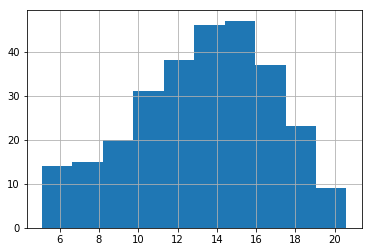

In [424]:
acts.score.hist()

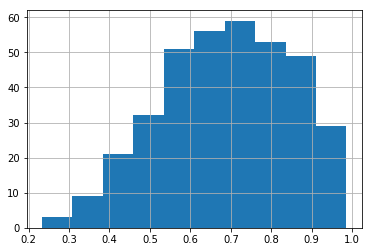

In [425]:
## looking at distribution of strain scores for days
whoop.strain.apply(lambda x: np.nan if x=='---' else x/21.0).astype(float).hist()

In [426]:
## need to fix some of the nulls in the activity data, by regenerating it with the whoop data
whoop.head()
whoop.isnull().sum()

strain              0
recovery            0
sleep_perf          6
sleep               6
rec_sleep           0
date                0
date_string         0
activity_1          0
activity_1_score    0
activity_2          0
activity_2_score    0
activity_3          0
activity_3_score    0
dtype: int64

In [427]:
## figuring out what to do with these
whoop[(whoop.recovery=='---')|(whoop.sleep=='---')|(whoop.rec_sleep=='---')|whoop.recovery.isnull()|whoop.sleep.isnull()]


,strain,recovery,sleep_perf,sleep,rec_sleep,date,date_string,activity_1,activity_1_score,activity_2,activity_2_score,activity_3,activity_3_score
0,---,---,---%,---,---,"Today, May 27th",5/27/2019,null,null,null,null,null,null
47,4.9,---,---%,---,---,"Wed, Apr 10th",4/10/2019,null,null,null,null,null,null
62,10.6,Pending,NaN,NaN,0:00,"Tue, Mar 26th",3/26/2019,null,null,null,null,null,null
153,13.6,Pending,NaN,NaN,0:00,"Tue, Dec 25th",12/25/2018,Running,11.2,null,null,null,null
181,12,38%,NaN,NaN,8:44,"Tue, Nov 27th",11/27/2018,null,null,null,null,null,null
284,13.9,Incomplete\n Data,NaN,NaN,9:37,"Thu, Aug 16th",8/16/2018,Running,10.5,null,null,null,null
292,8.4,Incomplete\n Data,NaN,NaN,9:55,"Wed, Aug 8th",8/8/2018,null,null,null,null,null,null
352,15.7,Incomplete\n Data,NaN,NaN,10:11,"Sat, Jun 9th",6/9/2018,Swimming,13.1,null,null,null,null


In [428]:
## for recovery, I think i want to take the average or the rolling previous 3 day average
testing=whoop.copy(deep=True)
testing['rec']=testing['recovery'].astype(str).apply(lambda x: np.nan if '%' not in x else float(x[:len(x)-1])/100)
testing['rec'].mean() ## avg is .53
testing['missing_rec_p3']=testing.sort_values('date_string')['rec'].shift(1).rolling(3).mean()
testing[testing.rec.isnull()].missing_rec_p3.mean() ## average of rolling previous 3 is .5106 (seems fair)


0.508095238095238

In [429]:
def time_to_dec(t):
    if ":" in t:
        hr=float(t[:t.find(':')])
        m=float(t[t.find(':')+1:])/60
        return hr+m
    else:
        return np.nan

In [430]:
## for sleep, I think i want to do the average recommended sleep gap (when present, otherwise I'll do avg sleep for a tuesday)
testing.sleep=testing.sleep.astype(str).apply(time_to_dec)
testing.rec_sleep=testing.rec_sleep.astype(str).apply(lambda x: time_to_dec(x) if x!=0 else x)
testing['sleep_perf']=testing['sleep_perf'].astype(str).apply(lambda x: np.nan if '-' in x or "na" in x else float(x[:len(x)-1])/100)
testing.rec_sleep.mean(),testing.sleep_perf.mean() ## so sleep needs to be .717 * rec sleep if present

(9.341089566020313, 0.7171267605633803)

In [431]:
## avg sleep for a tuesday and wednesday
testing[testing['date'].str.contains('Tue')].sleep.mean(),testing[testing['date'].str.contains('Wed')].sleep.mean()
testing[testing['date'].str.contains('Tue')].rec_sleep.mean(),testing[testing['date'].str.contains('Wed')].rec_sleep.mean()

(9.046732026143792, 9.27875816993464)

In [432]:
whoop['rec']=whoop['recovery'].astype(str).apply(lambda x: np.nan if '%' not in x else float(x[:len(x)-1])/100)
whoop['missing_rec_p3']=whoop.sort_values('date_string')['rec'].shift(1).rolling(3).mean()
whoop['fixed_recovery']=whoop.apply(lambda x: x.rec if ~np.isnan(x.rec) else x.missing_rec_p3,axis=1)
whoop[whoop.fixed_recovery.isnull()]

,strain,recovery,sleep_perf,sleep,rec_sleep,date,date_string,activity_1,activity_1_score,activity_2,activity_2_score,activity_3,activity_3_score,rec,missing_rec_p3,fixed_recovery


In [452]:
whoop['fixed_sleep_1']=whoop.sleep.astype(str).apply(time_to_dec)
whoop['fixed_rec_sleep_1']=whoop.rec_sleep.astype(str).apply(lambda x: time_to_dec(x) if x!=0 else x)
whoop['fixed_sleep_perf']=whoop['sleep_perf'].astype(str).apply(lambda x: np.nan if '-' in x or "na" in x else float(x[:len(x)-1])/100)
whoop['fixed_sleep']=whoop.apply(lambda x: x.fixed_sleep_1 if ~np.isnan(x.fixed_sleep_1) else (6.77 if 'Tue' in x['date'] else (6.45 if 'Wed' in x['date'] else .717*x.fixed_rec_sleep_1)),axis=1)
whoop[whoop['fixed_sleep'].isnull()]
whoop['fixed_rec_sleep']=whoop.apply(lambda x: x.fixed_rec_sleep_1 
                                           if ~np.isnan(x.fixed_rec_sleep_1) and x.fixed_rec_sleep_1!=0 else
                                           (9.05 if 'Tue' in x['date'] else 
                                           (9.28 if 'Wed' in x['date'] else 9.34)),axis=1)
## fixing the sleep performance after imputing the nulls for rec sleep and actual sleep, to allow the pieces on tuesday/wed sleep
whoop.fixed_sleep_perf=whoop.apply(lambda x: 
                           x.fixed_sleep_perf if ~np.isnan(x.fixed_sleep_perf) else
                           1.0*x.fixed_sleep/x.fixed_rec_sleep,axis=1)                              

In [453]:
whoop.head()

,strain,recovery,sleep_perf,sleep,rec_sleep,date,date_string,activity_1,activity_1_score,activity_2,activity_2_score,activity_3,activity_3_score,rec,missing_rec_p3,fixed_recovery,fixed_sleep_1,fixed_rec_sleep_1,fixed_sleep_perf,fixed_sleep,fixed_rec_sleep,week,month
0,---,---,---%,---,---,"Today, May 27th",5/27/2019,null,null,null,null,null,null,NaN,0.493333,0.493333,NaN,NaN,NaN,NaN,9.340000,2019-21,2019-05
1,15,24%,47%,4:23,9:24,"Sun, May 26th",5/26/2019,Golf,12.5,null,null,null,null,0.24,0.583333,0.240000,4.383333,9.400000,0.47,4.383333,9.400000,2019-20,2019-05
2,20.4,53%,91%,8:57,9:53,"Sat, May 25th",5/25/2019,Running,19.8,null,null,null,null,0.53,0.710000,0.530000,8.950000,9.883333,0.91,8.950000,9.883333,2019-20,2019-05
3,16.8,71%,73%,6:50,9:22,"Fri, May 24th",5/24/2019,Running,13.3,Activity,8.1,null,null,0.71,0.700000,0.710000,6.833333,9.366667,0.73,6.833333,9.366667,2019-20,2019-05
4,12,51%,66%,6:45,10:14,"Thu, May 23rd",5/23/2019,null,null,null,null,null,null,0.51,0.780000,0.510000,6.750000,10.233333,0.66,6.750000,10.233333,2019-20,2019-05


In [454]:
## adding average strain for previous week and month
whoop['week']=pd.to_datetime(whoop.date_string).dt.strftime("%Y-%W")
whoop['month']=pd.to_datetime(whoop.date_string).dt.strftime("%Y-%m")
whoop_agg=whoop.copy(deep=True)
if whoop_agg.strain.dtype=='O':
    whoop_agg.strain=whoop_agg.strain.apply(lambda x: float(x) if x!="---" else 0)
whoop_agg_month=whoop_agg.sort_values('date_string').groupby('month',group_keys=False).agg({
    "strain":{'avg_strain_last_month':'mean'},
    'fixed_recovery':{'avg_rec_last_month':'mean'},
    'fixed_sleep_perf':{'avg_sleep_perf_last_month':'mean'}}).shift(1)
whoop_agg_month.columns=whoop_agg_month.columns.droplevel()

## i'm just going to drop may 2018 since i won't really use it anyhow
whoop_agg_month.drop(['2018-05'],inplace=True)

## dropping the first week for the same reason
whoop_agg_week=whoop_agg.sort_values('date_string').groupby('week',group_keys=False).agg({
    "strain":{'avg_strain_last_week':'mean'},
    'fixed_recovery':{'avg_rec_last_week':'mean'},
    'fixed_sleep_perf':{'avg_sleep_perf_last_week':'mean'}}).shift(1)
whoop_agg_week.columns=whoop_agg_week.columns.droplevel()
whoop_agg_week.drop(['2018-22'],inplace=True)

whoop_agg_vars=whoop_agg.merge(
    whoop_agg_month,how ='left',left_on='month',right_index=True).merge(
    whoop_agg_week,how='left',left_on='week',right_index=True)

## making diff variables
whoop_agg_vars['strain_diff_last_month']=whoop_agg_vars.strain-whoop_agg_vars.avg_strain_last_month
whoop_agg_vars['rec_diff_last_month']=whoop_agg_vars.fixed_recovery-whoop_agg_vars.avg_rec_last_month
whoop_agg_vars['sleep_perf_diff_last_month']=whoop_agg_vars.fixed_sleep_perf-whoop_agg_vars.avg_sleep_perf_last_month

whoop_agg_vars['strain_diff_last_week']=whoop_agg_vars.strain-whoop_agg_vars.avg_strain_last_week
whoop_agg_vars['rec_diff_last_week']=whoop_agg_vars.fixed_recovery-whoop_agg_vars.avg_rec_last_week
whoop_agg_vars['sleep_perf_diff_last_week']=whoop_agg_vars.fixed_sleep_perf-whoop_agg_vars.avg_sleep_perf_last_week

/Users/irarickman/anaconda2/envs/py35/lib/python3.6/site-packages/pandas/core/groupby/groupby.py:4656: FutureWarning:

using a dict with renaming is deprecated and will be removed in a future version



In [455]:
all_whoop=whoop_agg_vars.drop(['rec','recovery','sleep','sleep_perf','fixed_sleep_1',
                      'missing_rec_p3','rec_sleep','fixed_rec_sleep_1','week','month'],axis=1)
all_whoop.head()
rnm={x:x.replace("fixed_",'') for x in all_whoop.columns if 'fixed' in x}

all_whoop.rename(columns=rnm,inplace=True)

In [471]:

all_whoop['rec_color']=all_whoop.recovery.apply(lambda x: 'red' if x<.34 else ('yellow' if x<.67 else ('none' if np.isnan(x) else 'green') ))
if whoop.strain.dtype=='O':
    all_whoop.strain=all_whoop.strain.apply(lambda x: float(x) if x!="---" else 0)
if all_whoop.date_string.dtype!='<M8[ns]':
    all_whoop.date_string=pd.to_datetime(all_whoop.date_string)
all_whoop['sleep_addition']=all_whoop.rec_sleep-7.75
all_whoop['pday_rec']=all_whoop['recovery'].shift(-1)
all_whoop['pday_rec_col']=all_whoop['rec_color'].shift(-1)
for n in range(1,4):
    act_num="activity_{}_score".format(n)
    all_whoop[act_num]=all_whoop[act_num].apply(lambda x: np.nan if x=='null' else x)
all_whoop['activity_total']=all_whoop[['activity_1_score','activity_2_score','activity_3_score']].apply(lambda x: sum([0 if y=='null' else (0 if np.isnan(y) else 1) for y in x ]),axis=1 )
all_whoop['pday_acts']=all_whoop['activity_total'].shift(-1)
all_whoop['pday_strain']=all_whoop['strain'].shift(-1)
all_whoop['pday_sleep']=all_whoop.sleep.shift(-1)
all_whoop['pday_sleep_perf']=all_whoop.sleep_perf.shift(-1)
all_whoop['rolling_prev_2']=all_whoop.sort_values('date_string').pday_sleep.rolling(2).mean()
all_whoop['prev_strain_rec_gap']=all_whoop.pday_strain/21.0-all_whoop.pday_rec

act_1=all_whoop[['date','activity_1','activity_1_score']]
act_1.columns=['date','activity','score']
act_1['order']=1

act_2=all_whoop[['date','activity_2','activity_2_score']]
act_2.columns=['date','activity','score']
act_2['order']=2
act_2.dropna(inplace=True)

act_3=all_whoop[['date','activity_3','activity_3_score']]
act_3.columns=['date','activity','score']
act_3['order']=3
act_3.dropna(inplace=True)

full_whoop=pd.concat([act_1,act_2,act_3])
full_desc=all_whoop.drop(['activity_1','activity_2','activity_3','activity_1_score','activity_2_score','activity_3_score'],
                   axis=1)
whoop_df=full_desc.merge(full_whoop, how ='left',left_on='date',right_on='date')
whoop_df.head()

/Users/irarickman/anaconda2/envs/py35/lib/python3.6/site-packages/ipykernel_launcher.py:23: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/irarickman/anaconda2/envs/py35/lib/python3.6/site-packages/ipykernel_launcher.py:27: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/irarickman/anaconda2/envs/py35/lib/python3.6/site-packages/ipykernel_launcher.py:28: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/ind

,strain,date,date_string,recovery,sleep_perf,sleep,rec_sleep,avg_strain_last_month,avg_rec_last_month,avg_sleep_perf_last_month,avg_strain_last_week,avg_rec_last_week,avg_sleep_perf_last_week,strain_diff_last_month,rec_diff_last_month,sleep_perf_diff_last_month,strain_diff_last_week,rec_diff_last_week,sleep_perf_diff_last_week,rec_color,sleep_addition,pday_rec,pday_rec_col,activity_total,pday_acts,pday_strain,pday_sleep,pday_sleep_perf,rolling_prev_2,prev_strain_rec_gap,activity,score,order
0,0.0,"Today, May 27th",2019-05-27,0.493333,NaN,NaN,9.340000,14.606667,0.454778,0.769168,16.271429,0.618571,0.691429,-14.606667,0.038556,NaN,-16.271429,-0.125238,NaN,yellow,1.590000,0.24,red,0,1.0,15.0,4.383333,0.47,6.666667,0.474286,null,NaN,1
1,15.0,"Sun, May 26th",2019-05-26,0.240000,0.47,4.383333,9.400000,14.606667,0.454778,0.769168,16.185714,0.448571,0.682857,0.393333,-0.214778,-0.299168,-1.185714,-0.208571,-0.212857,red,1.650000,0.53,yellow,1,1.0,20.4,8.950000,0.91,7.891667,0.441429,Golf,12.5,1
2,20.4,"Sat, May 25th",2019-05-25,0.530000,0.91,8.950000,9.883333,14.606667,0.454778,0.769168,16.185714,0.448571,0.682857,5.793333,0.075222,0.140832,4.214286,0.081429,0.227143,yellow,2.133333,0.71,green,1,2.0,16.8,6.833333,0.73,6.791667,0.090000,Running,19.8,1
3,16.8,"Fri, May 24th",2019-05-24,0.710000,0.73,6.833333,9.366667,14.606667,0.454778,0.769168,16.185714,0.448571,0.682857,2.193333,0.255222,-0.039168,0.614286,0.261429,0.047143,green,1.616667,0.51,yellow,2,0.0,12.0,6.750000,0.66,6.283333,0.061429,Running,13.3,1
4,16.8,"Fri, May 24th",2019-05-24,0.710000,0.73,6.833333,9.366667,14.606667,0.454778,0.769168,16.185714,0.448571,0.682857,2.193333,0.255222,-0.039168,0.614286,0.261429,0.047143,green,1.616667,0.51,yellow,2,0.0,12.0,6.750000,0.66,6.283333,0.061429,Activity,8.1,2


In [480]:
whoop_df[whoop_df.date_string=="2019-04-10"]

,strain,date,date_string,recovery,sleep_perf,sleep,rec_sleep,avg_strain_last_month,avg_rec_last_month,avg_sleep_perf_last_month,avg_strain_last_week,avg_rec_last_week,avg_sleep_perf_last_week,strain_diff_last_month,rec_diff_last_month,sleep_perf_diff_last_month,strain_diff_last_week,rec_diff_last_week,sleep_perf_diff_last_week,rec_color,sleep_addition,pday_rec,pday_rec_col,activity_total,pday_acts,pday_strain,pday_sleep,pday_sleep_perf,rolling_prev_2,prev_strain_rec_gap,activity,score,order
53,4.9,"Wed, Apr 10th",2019-04-10,0.533333,0.695043,6.45,9.28,15.519355,0.506559,0.757034,15.385714,0.534286,0.752857,-10.619355,0.026774,-0.061991,-10.485714,-0.000952,-0.057814,yellow,1.53,0.42,yellow,0,1.0,15.2,6.433333,0.72,6.975,0.30381,null,NaN,1


In [472]:
print(single_acts.columns)
strava_keep=['miles','date_string','moving_minutes','elapsed_minutes','rest','avg_mph','time_since_last_act','start_date',
             'total_elevation_gain','race','order','miles_last_month','avg_mph_last_month', 'miles_last_week', 
             'avg_mph_last_week','miles_pct_last_week', 'miles_pct_last_month', 'mph_diff_last_week',
             'mph_diff_last_month']
strava_df=single_acts[strava_keep]

Index(['achievement_count', 'athlete_count', 'average_speed', 'average_watts',
       'comment_count', 'commute', 'device_watts', 'distance', 'elapsed_time',
       'elev_high', 'elev_low', 'external_id', 'flagged', 'gear_id',
       'has_kudoed', 'id', 'kilojoules', 'kudos_count', 'manual', 'max_speed',
       'max_watts', 'moving_time', 'name', 'photo_count', 'private',
       'start_date', 'start_date_local', 'timezone', 'total_elevation_gain',
       'total_photo_count', 'trainer', 'type', 'upload_id',
       'weighted_average_watts', 'workout_type', 'miles', 'race',
       'date_string', 'moving_minutes', 'elapsed_minutes', 'rest', 'avg_mph',
       'time_since_last_act', 'order', 'miles_last_month',
       'avg_mph_last_month', 'miles_last_week', 'avg_mph_last_week',
       'miles_pct_last_week', 'miles_pct_last_month', 'mph_diff_last_week',
       'mph_diff_last_month', 'multi_act', 'multi_run'],
      dtype='object')


In [481]:
if whoop_df.date_string.dtype!='<M8[ns]':
    whoop_df.date_string=pd.to_datetime(whoop_df.date_string)
strava_df.date_string=pd.to_datetime(strava_df.date_string)
data=whoop_df.merge(strava_df, left_on=['date_string','order'],right_on=['date_string','order'])
data.sort_values('date_string').head()
## dropping the first two dates
## also dropping april 10th because i didn't wear my whoop that day
data=data[~data.date_string.isin(['2018-05-31','2018-06-03','2019-04-10'])]
data.isnull().sum()

/Users/irarickman/anaconda2/envs/py35/lib/python3.6/site-packages/pandas/core/generic.py:4405: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



strain                        0
date                          0
date_string                   0
recovery                      0
sleep_perf                    0
sleep                         0
rec_sleep                     0
avg_strain_last_month         0
avg_rec_last_month            0
avg_sleep_perf_last_month     0
avg_strain_last_week          0
avg_rec_last_week             0
avg_sleep_perf_last_week      0
strain_diff_last_month        0
rec_diff_last_month           0
sleep_perf_diff_last_month    0
strain_diff_last_week         0
rec_diff_last_week            0
sleep_perf_diff_last_week     0
rec_color                     0
sleep_addition                0
pday_rec                      0
pday_rec_col                  0
activity_total                0
pday_acts                     0
pday_strain                   0
pday_sleep                    0
pday_sleep_perf               0
rolling_prev_2                0
prev_strain_rec_gap           0
activity                      0
score   

In [482]:
data[data.time_since_last_act.isnull()]

,strain,date,date_string,recovery,sleep_perf,sleep,rec_sleep,avg_strain_last_month,avg_rec_last_month,avg_sleep_perf_last_month,avg_strain_last_week,avg_rec_last_week,avg_sleep_perf_last_week,strain_diff_last_month,rec_diff_last_month,sleep_perf_diff_last_month,strain_diff_last_week,rec_diff_last_week,sleep_perf_diff_last_week,rec_color,sleep_addition,pday_rec,pday_rec_col,activity_total,pday_acts,pday_strain,pday_sleep,pday_sleep_perf,rolling_prev_2,prev_strain_rec_gap,activity,score,order,miles,moving_minutes,elapsed_minutes,rest,avg_mph,time_since_last_act,start_date,total_elevation_gain,race,miles_last_month,avg_mph_last_month,miles_last_week,avg_mph_last_week,miles_pct_last_week,miles_pct_last_month,mph_diff_last_week,mph_diff_last_month
0,20.4,"Sat, May 25th",2019-05-25,0.53,0.91,8.95,9.883333,14.606667,0.454778,0.769168,16.185714,0.448571,0.682857,5.793333,0.075222,0.140832,4.214286,0.081429,0.227143,yellow,2.133333,0.71,green,1,2.0,16.8,6.833333,0.73,6.791667,0.09,Running,19.8,1,11.004791,97.95,104.316667,6.366667,6.742318,NaN,2019-05-25 10:47:46+00:00,63.0,0.0,139.240977,7.065081,36.359213,7.037267,0.302669,0.079034,-0.294949,-0.322763


In [463]:
data.columns

Index(['strain', 'date', 'date_string', 'recovery', 'sleep_perf', 'sleep',
       'rec_sleep', 'avg_strain_last_month', 'avg_rec_last_month',
       'avg_sleep_perf_last_month', 'avg_strain_last_week',
       'avg_rec_last_week', 'avg_sleep_perf_last_week',
       'strain_diff_last_month', 'rec_diff_last_month',
       'sleep_perf_diff_last_month', 'strain_diff_last_week',
       'rec_diff_last_week', 'sleep_perf_diff_last_week', 'rec_color',
       'sleep_addition', 'pday_rec', 'pday_rec_col', 'activity_total',
       'pday_acts', 'pday_strain', 'pday_sleep', 'pday_sleep_perf',
       'rolling_prev_2', 'prev_strain_rec_gap', 'activity', 'score', 'order',
       'miles', 'moving_minutes', 'elapsed_minutes', 'rest', 'avg_mph',
       'time_since_last_act', 'start_date', 'total_elevation_gain', 'race',
       'miles_last_month', 'avg_mph_last_month', 'miles_last_week',
       'avg_mph_last_week', 'miles_pct_last_week', 'miles_pct_last_month',
       'mph_diff_last_week', 'mph_diff_last_m

In [464]:
# adding a column for a weekday
data['weekday']=data['date'].apply(lambda x: 0 if 'Sat' in x or 'Sun' in x else 1 )
data.weekday.value_counts()

1    120
0     42
Name: weekday, dtype: int64

In [267]:
data.dropna(inplace=True)
X=data.drop(['strain','date','rec_color','pday_rec_col','activity_total','date_string','activity','score',
                 'order','start_date','sleep','pday_rec','rec_sleep','pday_sleep'],axis=1) ## dropping pday_rec and sleep because of correlation with other better metrics
y=data.score

In [295]:
## linear reg function
def linreg_infer(subset=False, x=X, targ=y):
    if subset!=False:
        x=X[subset]
    x=sm.add_constant(x)
    lr=sm.OLS(y, x)
    res=lr.fit()
    print(res.summary())

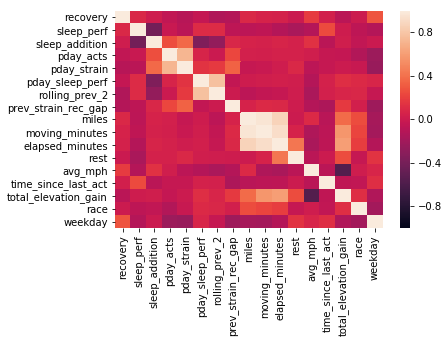

In [269]:
sns.heatmap(X.corr(),vmin=-1, vmax=1)

In [270]:
data[['prev_strain_rec_gap','pday_rec']].corr()

,prev_strain_rec_gap,pday_rec
prev_strain_rec_gap,1.000000,-0.767052
pday_rec,-0.767052,1.000000


In [271]:
data[['sleep','sleep_perf','prev_strain_rec_gap','pday_rec','sleep_addition','rec_sleep']].corr()

,sleep,sleep_perf,prev_strain_rec_gap,pday_rec,sleep_addition,rec_sleep
sleep,1.000000,0.909059,-0.025827,0.072991,-0.025393,-0.025393
sleep_perf,0.909059,1.000000,-0.066008,0.009057,-0.406906,-0.406906
prev_strain_rec_gap,-0.025827,-0.066008,1.000000,-0.767052,0.084021,0.084021
pday_rec,0.072991,0.009057,-0.767052,1.000000,0.169430,0.169430
sleep_addition,-0.025393,-0.406906,0.084021,0.169430,1.000000,1.000000
rec_sleep,-0.025393,-0.406906,0.084021,0.169430,1.000000,1.000000


In [272]:
data[['pday_sleep_perf','pday_sleep']].corr()

,pday_sleep_perf,pday_sleep
pday_sleep_perf,1.000000,0.913551
pday_sleep,0.913551,1.000000


In [273]:
X.columns

Index(['recovery', 'sleep_perf', 'sleep_addition', 'pday_acts', 'pday_strain',
       'pday_sleep_perf', 'rolling_prev_2', 'prev_strain_rec_gap', 'miles',
       'moving_minutes', 'elapsed_minutes', 'rest', 'avg_mph',
       'time_since_last_act', 'total_elevation_gain', 'race', 'weekday'],
      dtype='object')

In [274]:
## trying with just a subset
tryvars=['recovery','sleep_perf','sleep_addition','pday_acts','pday_strain','pday_sleep_perf','rolling_prev_2',
         'prev_strain_rec_gap','miles','rest','avg_mph','time_since_last_act','total_elevation_gain','race']
linreg_infer(tryvars)

                            OLS Regression Results                            
Dep. Variable:                  score   R-squared:                       0.634
Model:                            OLS   Adj. R-squared:                  0.599
Method:                 Least Squares   F-statistic:                     18.20
Date:                Sun, 26 May 2019   Prob (F-statistic):           1.56e-25
Time:                        17:06:21   Log-Likelihood:                -304.89
No. Observations:                 162   AIC:                             639.8
Df Residuals:                     147   BIC:                             686.1
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                    6.1984 

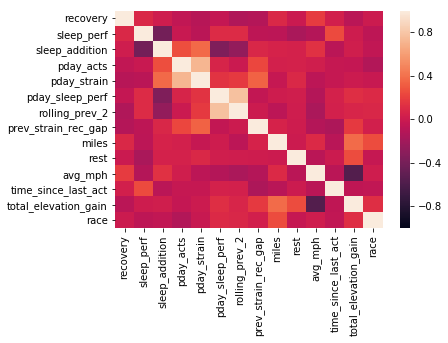

In [275]:
sns.heatmap(data[tryvars].corr(),vmin=-1,vmax=1)

In [276]:
data[tryvars].corr()

,recovery,sleep_perf,sleep_addition,pday_acts,pday_strain,pday_sleep_perf,rolling_prev_2,prev_strain_rec_gap,miles,rest,avg_mph,time_since_last_act,total_elevation_gain,race
recovery,1.000000,0.091647,0.023153,-0.051495,-0.097329,-0.033068,-0.130336,-0.112516,0.091366,-0.001662,0.186858,0.037016,-0.081242,0.002023
sleep_perf,0.091647,1.000000,-0.406906,-0.008917,-0.083353,0.102660,0.107322,-0.066008,-0.075124,-0.157916,-0.109839,0.245169,0.008417,-0.064809
sleep_addition,0.023153,-0.406906,1.000000,0.259516,0.371415,-0.356990,-0.259192,0.084021,0.058603,0.049175,0.139103,-0.079149,0.031196,-0.052981
pday_acts,-0.051495,-0.008917,0.259516,1.000000,0.722063,0.064534,-0.000433,0.233188,0.046661,0.053043,0.030678,-0.031150,-0.031357,-0.119304
pday_strain,-0.097329,-0.083353,0.371415,0.722063,1.000000,0.144947,0.178959,0.339336,-0.027761,0.087358,-0.070866,-0.030521,0.005706,-0.022549
pday_sleep_perf,-0.033068,0.102660,-0.356990,0.064534,0.144947,1.000000,0.780198,-0.045663,0.009186,0.029284,-0.115654,0.051877,0.123451,0.097080
rolling_prev_2,-0.130336,0.107322,-0.259192,-0.000433,0.178959,0.780198,1.000000,0.005981,-0.073267,0.019455,-0.148659,0.040867,0.070943,0.083338
prev_strain_rec_gap,-0.112516,-0.066008,0.084021,0.233188,0.339336,-0.045663,0.005981,1.000000,0.057509,0.011244,-0.112315,-0.145265,0.173103,0.038465
miles,0.091366,-0.075124,0.058603,0.046661,-0.027761,0.009186,-0.073267,0.057509,1.000000,0.007068,0.095335,-0.089889,0.375605,0.254397
rest,-0.001662,-0.157916,0.049175,0.053043,0.087358,0.029284,0.019455,0.011244,0.007068,1.000000,-0.084255,0.007521,0.252543,-0.026078


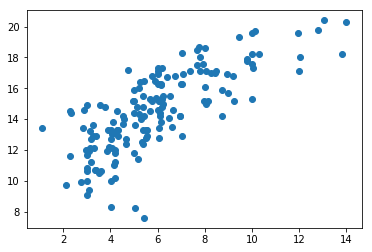

In [277]:
plt.scatter(data.miles,data.score)

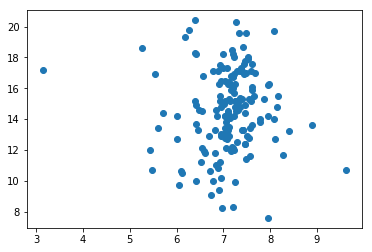

In [278]:
plt.scatter(data.avg_mph,data.score)

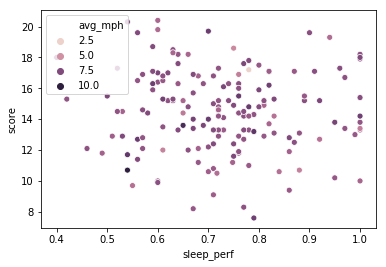

In [279]:
sns.scatterplot('sleep_perf','score',hue='avg_mph',data=data)

[0.84787518 0.92146922 0.98507316 0.99844789 0.99973394 0.99984703
 0.9999005  0.99994127 0.99996188 0.99998028 0.99998692 0.99999211
 0.99999654 0.99999815 0.99999927 1.         1.        ]


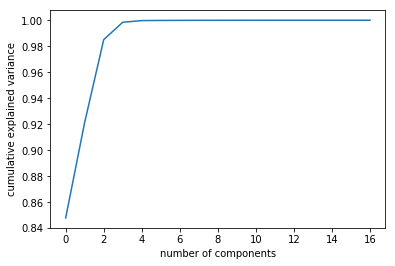

In [290]:
## looking at pca variance
pca=PCA(n_components=17)
pca_comps=pca.fit(X)
plt.plot(np.cumsum(pca_comps.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance');
print(np.cumsum(pca_comps.explained_variance_ratio_))

In [297]:
pca_x=PCA(n_components=4).fit_transform(X)
linreg_infer(x=pca_x)

                            OLS Regression Results                            
Dep. Variable:                  score   R-squared:                       0.590
Model:                            OLS   Adj. R-squared:                  0.580
Method:                 Least Squares   F-statistic:                     56.55
Date:                Sun, 26 May 2019   Prob (F-statistic):           1.80e-29
Time:                        17:25:05   Log-Likelihood:                -314.07
No. Observations:                 162   AIC:                             638.1
Df Residuals:                     157   BIC:                             653.6
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         14.5389      0.134    108.331      0.0

In [309]:
pca = PCA()
lr = LinearRegression()

# make a pipeline that chains together the pca and the linear regression
# this means that when the X data gets "piped in" it first hits the PCA,
# which will fit it to the data, then transform the original variables
# into their principal component "new variables".

# From here these principal components get sent into the linear regression
# to be fit.

# This is very useful because we can actually gridsearch the number of 
# components - gridsearch is designed to run on models that return
# some kind of score. The PCA has no score, it's just transforming the
# variables. So gridsearching the PCA itself is meaningless.

# However, if it then goes to a linear regression after, we can score
# it on some dependent variable in order to determine which number
# of components was the best one!

pca_pipe = make_pipeline(pca, lr)

pca_grid = {
    'pca__n_components':[1,2,3,4,5]
}

# Gridsearch now takes the pipeline:
#pca_gs = GridSearchCV(pca_pipe, pca_grid, cv=3,scoring='neg_mean_squared_error')
pca_gs = GridSearchCV(pca_pipe, pca_grid, cv=3,scoring='r2')

# fit it on the data X, y as usual
pca_gs.fit(X, y)

print(pca_gs.best_params_)
print(pca_gs.best_score_)

{'pca__n_components': 3}
0.5084177051611575
